<a href="https://colab.research.google.com/github/Svhugani/QOptics/blob/main/LepNumericalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Należy wykonać wszystkie komórki, aby uzyskać nowe wyniki.

In [1]:
pip install qutip

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import pandas as pd

In [154]:

class QuantumSystem:

  def __init__( self, isBalanced, omega, gamma_1, gamma_3, gSpace, dim, roundDecimals):
    
    self.isBalanced = isBalanced
    self.omega = omega
    self.gamma_1 = gamma_1
    self.gamma_3 = gamma_3
    self.dim = dim
    self.gSpace = gSpace
    self.Energies = None
    self.UniqueEnergies = np.empty(0)
    self.sysName = None
    self.roundDecimals = roundDecimals
    self.gExceptionals = None

  def SystemMatrix(self, g):
    I = qt.identity(self.dim)
    a1 = qt.tensor(qt.destroy(self.dim),I,I)
    a2 = qt.tensor(I,qt.destroy(self.dim),I)
    a3 = qt.tensor(I,I,qt.destroy(self.dim))

    H = self.omega * (a1.dag() * a1 + a2.dag() * a2 + a3.dag() * a3) + g * (a1.dag() * a2 + a2.dag() * a1 + a2.dag() * a3 + a3.dag() * a2 )
    L = -1.0j * (qt.spre(H) - qt.spost(H))

    if self.isBalanced:
      L += self.gamma_1 * qt.lindblad_dissipator(a1)
      L += self.gamma_1 * qt.lindblad_dissipator(a3.dag())
      self.sysName = "balanced system"
    
    else:
      L += self.gamma_1 * qt.lindblad_dissipator(a1)
      L += self.gamma_3 * qt.lindblad_dissipator(a3)
      self.sysName = "unbalanced system"

    return [H, L]

  def UniqueEig(self, energy_df):
    uniques = list()
    energy_df_r = energy_df.round(self.roundDecimals)
    for i in range(energy_df_r.shape[0]):
      uniques.append(energy_df_r.iloc[i].unique().shape[0])
    
    self.UniqueEnergies = np.array(uniques)

  def FindExceptionals(self):
    if self.UniqueEnergies.shape[0] != 0:
      gExceptionals = list()
      newItem = None
      for i in range(self.UniqueEnergies.shape[0]):
        u = self.UniqueEnergies[i]
        if u != newItem:
          newItem = u
          gExceptionals.append(self.gSpace[i])
      
      self.gExceptionals = gExceptionals
    
    else:
      print("Detect unique Energies first !")



  def PlotSystemOfGspace(self, isHamiltionian, isRealPart):
    
    Energies = []

    if isHamiltionian:
      refInd = 0
      subTit = "HEP"
    else:
      refInd = 1
      subTit = "LEP"
    
    for gPoint in self.gSpace:
      system = self.SystemMatrix(gPoint)
      Energies.append(system[refInd].eigenenergies())
    
    Energies = np.array(Energies)
    self.Energies = Energies

    if isRealPart:
      title = "Real"
      Energies = Energies.real
      energy_df = pd.DataFrame(self.Energies.real)
    
    else:
      title = "Imaginary"
      Energies = Energies.imag
      energy_df = pd.DataFrame(self.Energies.imag)

    fig, ax = plt.subplots(nrows = 1, ncols = 2,  figsize=(30,10))
    ax[0].grid()
    ax[1].grid()
    
    for i in range(len(Energies[0])):
      Y = Energies[ : , i ]
      ax[0].scatter(self.gSpace, Y, label = "e" + str(i), s = 8, marker = 'o')
      
    energyVar = energy_df.var(axis = 1)
    self.UniqueEig(energy_df)
    
    ax[1].plot(self.gSpace, energyVar, label = "variance of all eigenvals at g", linewidth = 3, linestyle = "solid")
    ax[1].plot(self.gSpace, ((max(energyVar) - min(energyVar)) / max(self.UniqueEnergies) * self.UniqueEnergies + min(energyVar)), label = "scaled num of unique eigenvals at g with given accuracy", linewidth = 3, linestyle = "dotted", color = "red")

    ax[0].title.set_text(str(title) + " parts of eigenvalues versus g graph")
    ax[1].title.set_text("Analysis of " + subTit)
  
    ax[1].legend(loc = "best")
    fig.suptitle(str(title) + " parts of eigenvalues versus  g for  " + subTit + " in " + self.sysName, fontsize=16)



**1. Analiza wartości rzeczywistych oraz zespolonych dla jednego z dwóch układów tzw zbalansowanego (zysk = strata) oraz niezbalansowanego (dwie różne straty).**

parametr bool: isBalanced - wybieramy czy badamy zbalansowany, czy ten drugi;

parametr bool: isHamiltonian - wybieramy czy badamy sam hamiltonian wybranego układu, jeżeli nie, to badamy Liouvillian ;

parametr bool isRealPart - wybieramy czy badamy część rzeczywistą, jeżeli nie to badana jest częśc zespolona;

parametr int subsystemDim - wymiar podprzestrzeni ( można dać ewentualnie 3, przy 4 wysiadka);

float omega - bez straty ogólności przyjęta za 1;

float gamma_1, gamma_3 = współczynniki interakcji, dla zbalansowanego używana jest tylko gamma_1;

parametr int roundDecimals - do ilu miejsc po przecinku zaokrąglamy części wartości własnych w celu liczenia "unikalnych" wartości własnych;


important g values: [0.0, 0.007035175879396984, 0.18291457286432158, 1.0904522613065326]


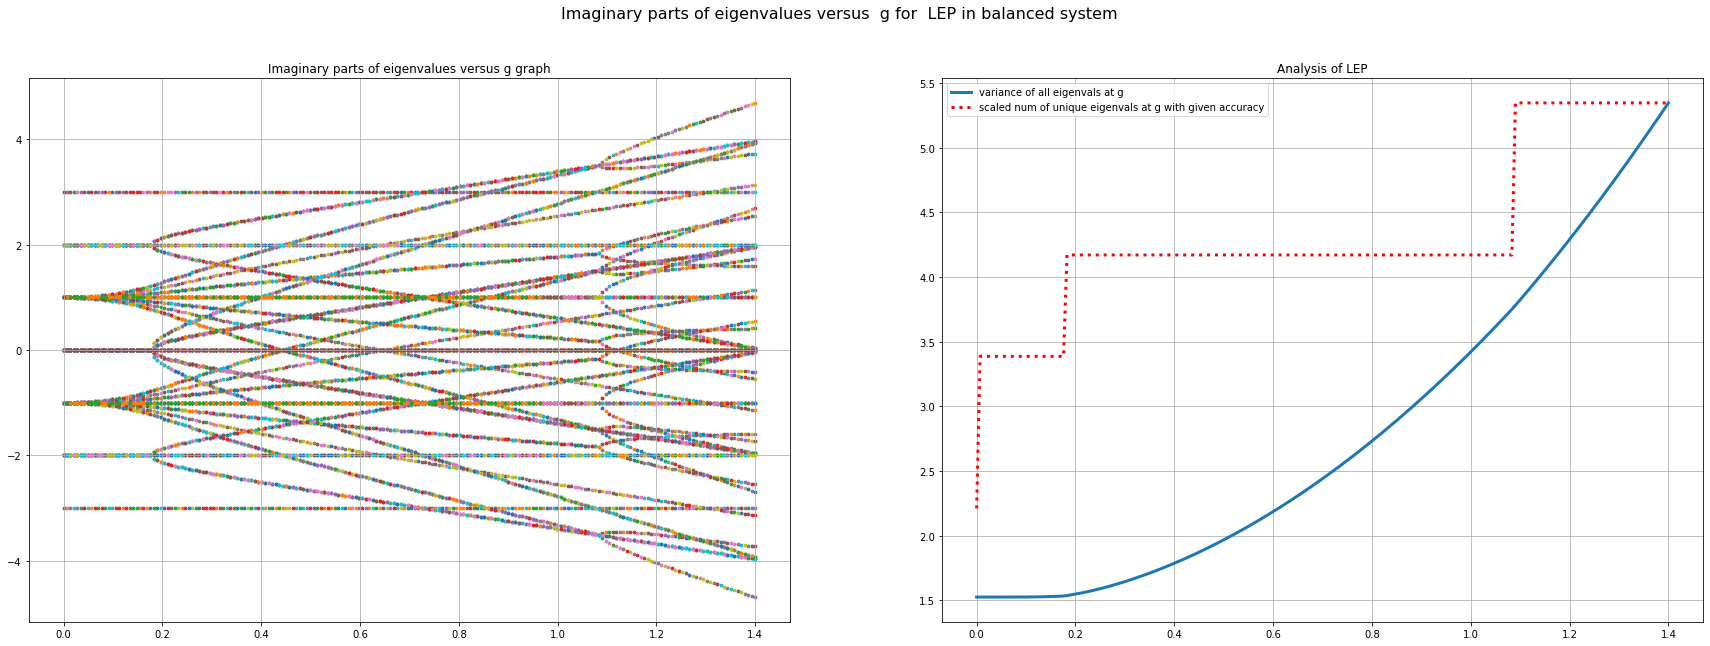

In [156]:
isBalanced = True
isHamiltonian = False
isRealPart = False
subsystemDim = 2
roundDecimals = 8

omega = 1
gamma_1 = omega
gamma_3 = omega / 2


QS = QuantumSystem(isBalanced, omega, gamma_1, gamma_3, np.linspace(0, 1.4, 200), subsystemDim, roundDecimals)
QS.PlotSystemOfGspace(isHamiltonian, isRealPart)
QS.FindExceptionals()
print("important g values: " + str(QS.gExceptionals))

In [161]:

class QuantumSystem:

  def __init__( self, isBalanced, omega, gamma_1Space, gamma_3, g, dim):
    
    self.isBalanced = isBalanced
    self.omega = omega
    self.gamma_1Space = gamma_1Space
    self.gamma_3 = gamma_3
    self.dim = dim
    self.g = g

  def SystemMatrix(self, gamma_1):
    I = qt.identity(self.dim)
    a1 = qt.tensor(qt.destroy(self.dim),I,I)
    a2 = qt.tensor(I,qt.destroy(self.dim),I)
    a3 = qt.tensor(I,I,qt.destroy(self.dim))

    H = self.omega * (a1.dag() * a1 + a2.dag() * a2 + a3.dag() * a3) + self.g * (a1.dag() * a2 + a2.dag() * a1 + a2.dag() * a3 + a3.dag() * a2 )
    L = -1.0j * (qt.spre(H) - qt.spost(H))

    if self.isBalanced:
      L += gamma_1 * qt.lindblad_dissipator(a1)
      L += gamma_1 * qt.lindblad_dissipator(a3.dag())
    
    else:
      L += gamma_1 * qt.lindblad_dissipator(a1)
      L += self.gamma_3 * qt.lindblad_dissipator(a3)

    return [H, L]

  def PlotSystemOfGspace(self, isHamiltionian, isRealPart):
    
    Energies = []

    if isHamiltionian:
      refInd = 0
    else:
      refInd = 1
    
    for gamma_1 in self.gamma_1Space:
      system = self.SystemMatrix(gamma_1)
      Energies.append(system[refInd].eigenenergies())
    
    Energies = np.array(Energies)

    if isRealPart:
      title = "Real"
      Energies = np.real(Energies)
    
    else:
      title = "Imaginary"
      Energies = np.imag(Energies)

    #colPlots = 4
    colPlots = 1
    plotsPerSubPlot =  64
    rowPlots = len(Energies[0]) / (colPlots * plotsPerSubPlot)  
    fig = plt.figure()
    fig.set_size_inches(20, 15)
    iterator = 0

    for i in range(len(Energies[0])):
      Y = Energies[ : , i ]

      if (i % plotsPerSubPlot == 0):
        iterator += 1
        ax = fig.add_subplot(rowPlots, colPlots, iterator)
        ax.grid()

      line = ax.scatter(self.gamma_1Space, Y, linestyle = "solid", linewidth = 2 ,label = "eig" + str(i))  

    #fig.legend()
    fig.suptitle(str(title) + " parts of eigenvalues versus gamma_1 / g", fontsize=16)
    plt.show()

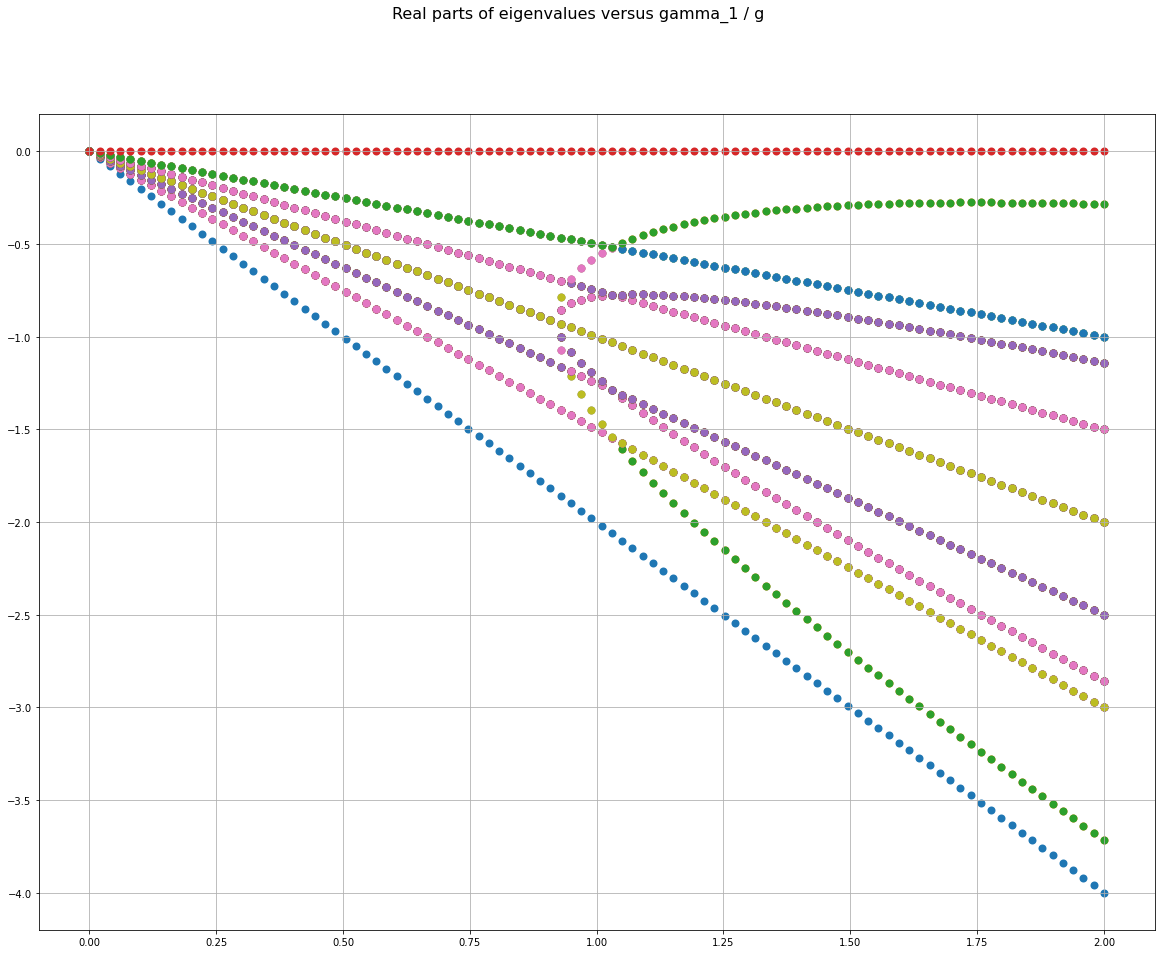

In [164]:
isBalanced = True
isHamiltonian = False
isRealPart = True
subsystemDim = 2

g = 1
omega = 5 * g
gamma_3 = 2.5 * g
gamma_1Space = np.linspace(0, 2, 100)


QS = QuantumSystem(isBalanced, omega, gamma_1Space, gamma_3, g, subsystemDim)
QS.PlotSystemOfGspace(isHamiltonian, isRealPart)

In [9]:
int(4/3)

1